In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ec487d1dc30890e86d3af0ab5a83696aec08c76bf3b7ea9fd7d2a287506f6284
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import math
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import os
from PIL import Image
import numpy as np
import pickle
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, StringType

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Tạo Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [ ]:
# model
def get_extract_model():
    vgg16_model = VGG16(weights="imagenet")
    extract_model=Model(inputs=vgg16_model.inputs, outputs=vgg16_model.get_layer("fc1").output)
    return extract_model

In [ ]:
#Chuyển hình ảnh thành tensor
def image_preprocess(img):
    img = img.resize((224,224))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
#Trích xuất vector
def extract_vector(model, image_path):
    print("Xu ly : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)
    # Trich dac trung
    vector = model.predict(img_tensor)[0]
    # Chuan hoa vector = chia chia L2 norm (tu google search)
    vector = vector / np.linalg.norm(vector)
    return vector

In [ ]:
data_folder = "/content/drive/MyDrive/DoAn_BD/dataset"
df= spark.read.format("image").load(data_folder)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

model = get_extract_model()
vectors = []
paths = []
for image_path in os.listdir(data_folder):
    # Noi full path
    image_path_full = os.path.join(data_folder, image_path)
    # Trich dac trung
    image_vector = extract_vector(model,image_path_full)
    # Add dac trung va full path vao list
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors,open(vector_file,'wb'))
pickle.dump(paths,open(path_file,"wb"))

553467096/553467096 [==============================] - 3s 0us/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4244.jpg
1/1 [==============================] - 1s 817ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4232.jpg
1/1 [==============================] - 1s 501ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4156.jpg
1/1 [==============================] - 1s 576ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4216.jpg
1/1 [==============================] - 1s 592ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4365.jpg
1/1 [==============================] - 1s 978ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4176.jpg
1/1 [==============================] - 1s 843ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4211.jpg
1/1 [==============================] - 1s 727ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4318.jpg
1/1 [==============================] - 0s 488ms/step
Xu ly :  /content/drive/MyDrive/DoAn_BD/dataset/4181.

KeyboardInterrupt: 

Xu ly :  /content/sutu.jpg


1/1 [==============================] - 1s 729ms/step


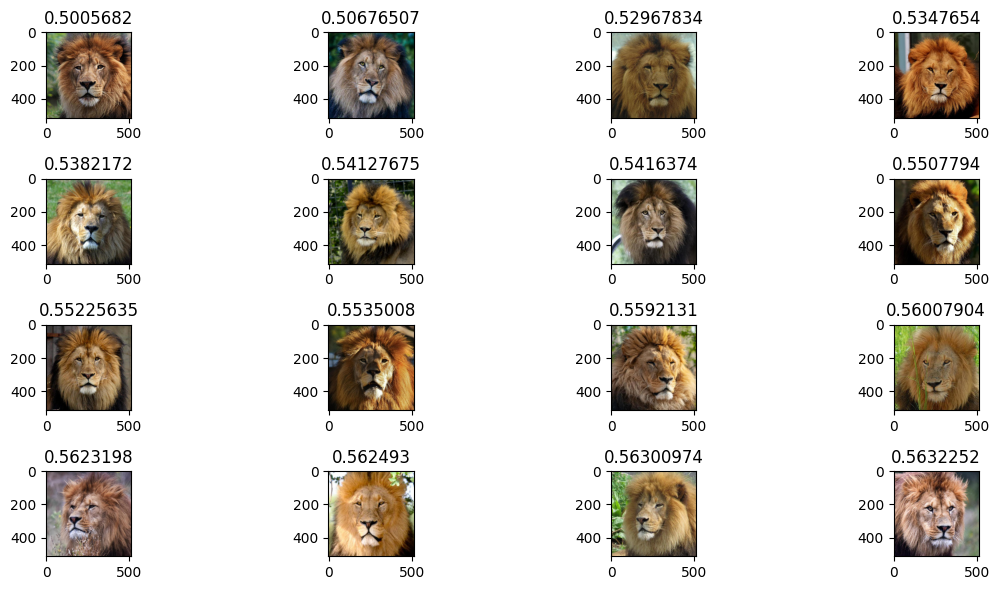

In [ ]:
search_image= "/content/sutu.jpg"

model = get_extract_model()
#trích xuất đặt trưng
search_vector= extract_vector(model,search_image)
#load 4700 vectors.pkl ra biến
vectors=pickle.load(open("/content/vectors.pkl","rb"))
paths=pickle.load(open("/content/paths.pkl","rb"))

#Tính khoản cách các vector đến ảnh cần tìm.
distance = np.linalg.norm(vectors - search_vector, axis=1)

#Xắp xếp và lấy ra k vector ngắn nhất
k= 16
ids =np.argsort(distance)[:k]
#Tạo output
nearest_image =[(paths[id],distance[id]) for id in ids]

#Hiển thị các ảnh giống nhất

axes=[]
grid_size =int(math.sqrt(k))
fig = plt.figure(figsize=(12,6))

for id in range(k):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size,grid_size,id+1))
    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()